# 2. odovzdanie
**termin: 11.4.2020**
- strucny opis prac inych autorov = related work 2 az 3 zdroje (1-2 vedecke)
    - clanky pracujuce s rovnakym datasetom, podobnou ulohou (nasa domena / podobna)
    - nevedecky zdroj - nieco z kagglu, blog ...nieco co viem odcitovat
    - zhrnutie: co dosiahli, ake data, ake algoritmy... mozme sa porovnat?
- predspracovanie
- DM metody
    - ake metody pouzijeme - regresia: linearna, NN, DST ...
- prvotne experimenty
    - prototyp na zahodenie
- vyhodnocovanie
    - praca v dalsej faze
    
### predpracovanie a vyber atributov (realizovanie scenara z analyzy)
- zjednotit formaty dat, oprava chybnych hodnot, ouliers (chyba/real), chybajuce hodnoty (priemerom, medianom, knn)
- transformacia dat (kategoricke na numericke)
- feature engineering
    - z existujucich crt odvodit nove
    - kombinacia existujucich
    - domenove znalosti
- feature selection
    - vyber podmnoziny atributov / crt
    - niektore robia same: lin. regresia, DST, RDF
    - filter (vyber pred trenovanim), wrapper (vyber naviazany na trenovany model), embed
    
- rozdelenie dat - train, valid, test split
- metriky vyhodnocovania (regresia - RMSE)

sablona: https://www.springer.com/gp/computer-science/lncs/conference-proceedings-guidelines?countryChanged=true

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

## Nacitanie dat

In [2]:
df = pd.read_csv('data/cars_raw.csv').drop('Unnamed: 0', axis=1)
df.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


## Predspracovanie dat
- na zaklade analyzy a popisu chyb

### Konvertovanie atributov na numericke hodnoty *Power, Engine, Mileage*

In [3]:
def convert_str_to_num(column):
    df[column] = df[column].apply(lambda x: str(x).split()[0])
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [4]:
convert_str_to_num('Power')
convert_str_to_num('Engine')
# convert_str_to_num('Mileage')     # toto budeme upravovat?

### Vytvorenie novej crty - *Manufacturer*

In [5]:
df['Manufacturer'] = df['Name'].apply(lambda x: str(x).split()[0])

### Odstranenie zbytocnych atributov - *New_Price*

In [6]:
df = df.drop(columns=["New_Price"], axis=1)

## Normalizacia hodnot

### Chybajuce hodnoty a outliery nahradime modusom rovnakeho vyrobcu
- 0 sedadiel nahradime poctom sedadiel rovnakeho auta, ak nie je tak rovnakej znacky
- extremne hodnoty kilometrov doplnime priemerom kilometrov aut rovnakeho roku vyroby (stihli najazdit cca rovnako)

In [7]:
df.loc[df['Seats'] == 0.0]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
3999,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000,Petrol,Automatic,First,10.5 kmpl,3197.0,NaN,0.0,18.0,Audi


In [8]:
# ine auta s rovnakym menom
df[(df['Name']=='Audi A4 3.2 FSI Tiptronic Quattro') & (df.index != 3999)]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer


In [9]:
# ine auta s rovnakou znackou
df[df['Manufacturer']=='Audi']['Seats'].value_counts()

5.0    192
7.0     38
4.0      3
2.0      2
0.0      1
Name: Seats, dtype: int64

In [10]:
df[df['Kilometers_Driven']>1000000]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97 kmpl,2993.0,258.0,5.0,65.0,BMW


In [11]:
# priemerne najazdene KM u aut z rovnakym rokom vyroby
df[df['Year']==2017]['Kilometers_Driven'].mean()

44728.38841567291

In [12]:
# pre porovnanie celkovy priemer najazdenych KM
df['Kilometers_Driven'].mean()

58738.38029573019

## Rozdelenie na train-test

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Price'], df['Price'], test_size=0.2, random_state=42)

## Odstranenie outlierov
- pri KM_Driven, Engine, Power
- je to nutne?

In [90]:
def quantile_replace(column):
    q01 = X_train[column].quantile(0.01)
    q99 = X_train[column].quantile(0.99)
    print(len(df[df[column]<q01]),len(df[df[column]>q99]))
    X_train[column] = X_train[column].apply(lambda x: q99 if x > q99 
                                            else q01 if x < q01 else x)
    X_test[column] = X_test[column].apply(lambda x: q99 if x > q99 
                                            else q01 if x < q01 else x)
    print(q01, q99)

In [93]:
quantile_replace('Kilometers_Driven')

65 59
4230.82 173000.0


In [91]:
quantile_replace('Power')

60 54
38.650561486831265 300.0


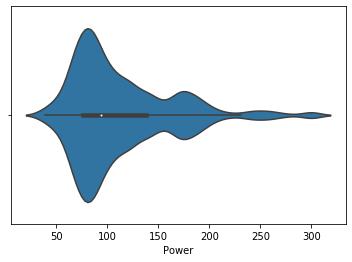

In [92]:
import seaborn as sns
sns.violinplot(x=X_train["Power"])

In [94]:
df.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998.0,58.16,5.0,1.75,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582.0,126.20,5.0,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199.0,88.70,5.0,4.50,Honda
